# SimplicialCliqueLifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Create NN model](#create-nn-model) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Run](#run) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
***

### Imports and utilities

In [10]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pprint
import rootutils

rootutils.setup_root("./", indicator=".project-root", pythonpath=True)
root_folder = rootutils.find_root()
from modules.io.load.loaders import GraphLoader
from modules.io.preprocess.preprocessor import Preprocessor
from modules.utils.utils import (
    load_dataset_config,
    load_transform_config,
)

ImportError: cannot import name 'PreProcessor' from 'modules.io.preprocess.preprocessor' (/Users/gbg141/Documents/TopoProjectX/challenge-icml-2024/modules/io/preprocess/preprocessor.py)

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [16]:
dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
dataset = GraphLoader(dataset_config)

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': '/Users/gbg141/Documents/TopoProjectX/challenge-icml-2024/datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:

In [17]:
data = dataset.load()

## Loading and Applying the Lifting

Similarly, we can specify the transformation we want to apply through its type and id --the correxponding config files located at `/configs/transforms`. 

Note that the *tranform_config* dictionary generated below can contain a sequence of tranforms if it is needed.

In [18]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2simplicial/clique_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}

{'transform_type': 'lifting',
 'transform_name': 'SimplicialCliqueLifting',
 'complex_dim': 3,
 'preserve_edge_attr': False,
 'signed': True,
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcesor`:

In [11]:
dataset = PreProcessor(dataset.data_dir, data, transform_config)

Processing...
/opt/miniconda3/envs/topox/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
Done!


### Visualize graph

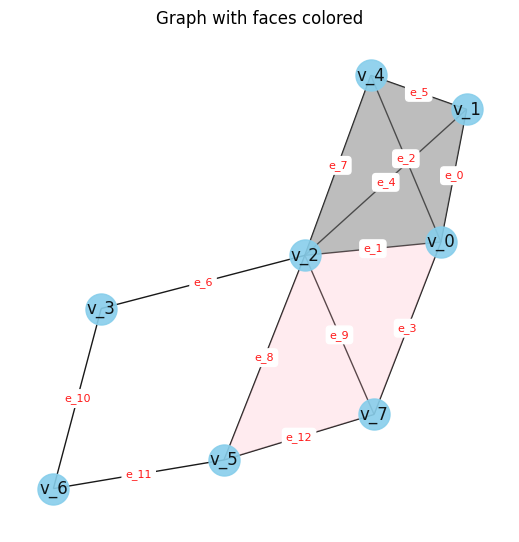

In [12]:
from modules.io.utils.utils import plot_manual_graph

plot_manual_graph(dataset)

## Create NN Model

In [13]:
from topomodelx.nn.simplicial.san import SAN
import torch


class Network(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, n_layers=1):
        super().__init__()
        self.base_model = SAN(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            n_layers=n_layers,
        )
        self.linear = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x = self.base_model(data.x_1, data.up_laplacian_1, data.down_laplacian_1)
        x = self.linear(x)
        return torch.sigmoid(x)

In [14]:
n_layers = 2
in_channels = dataset_config["num_features"]
hidden_channels = 32
out_channels = dataset_config["num_classes"]

model = Network(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    n_layers=n_layers,
)

## Run

In [15]:
y_hat = model(dataset)